<font size = 6>Evaluating the Longstaff-Schwartz Method for Pricing of American Options - American Options Pricing</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> Oct 28, 2022</div></font>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import norm
from numpy.polynomial.laguerre import lagval
from numpy.linalg import pinv
from sklearn.isotonic import IsotonicRegression as Isotonic
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Export path & Format
path = "D:\\Work\\"
path_format_P = ("Put_" + "%s" + "_S_" + "%s" + "_D_" + "%s" + "_N_" + "%s" + ".csv")
path_format_C = ("Call_" + "%s" + "_S_" + "%s" + "_D_" + "%s" + "_N_" + "%s" + ".csv") 

In [2]:
# Return Lagguerre Polynomial values(given degree)
def L(x_vec, degree, weighted = False):
    L = []
    for x in x_vec:
        L_temp = [1]
        for i in range(1, degree + 1):
            L_temp.append(lagval(x, [1] * (i+1)) - np.sum(L_temp))
        if not weighted:
            L.append(L_temp)
        else:
            L.append((np.array(L_temp) * np.exp(-x / 2)).tolist())  
    return np.array(L)

<font face="Times Roman" size=4>
    $\qquad$In this report, I will only use the Brownian bridge (conditional distribition of preceding elements) to simulate the paths backward from expiry (2.2 in Gustafsson's report) instead of the naive method which requires much more memory (2.1 in Gustafsson's report). And I am going to use Longstaff-Schwartz method to find the continuation values and exercise boundaries for American call and put options. <br>
</font>

# Replication of Gustafsson's Report

<font face="Times Roman" size=4>
    $\qquad$First of all, we set up the same parameters as what appears on Page 18 in Gustafsson's Report.
</font>

In [3]:
T = 1         # Time to expiry
K = 100       # Strike price
sigma = 0.15  # Volatility
r = 0.03      # Risk-free interest rate

<font face="Times Roman" size=4>
    $\qquad$In this part, I am going to replicate and assess the numerical results of Accuary (3.2 in Gustafsson's report) and finally make some necessary comments.<br>
    $\qquad$By the way, I am not going to explore the relationship between number of time steps and memroy like the author (3.1 in Gustafsson's report). <br>
</font>

<font face="Times Roman" size=4>
    <br>
    $\qquad$At the beginning, we could define some functions, which can make coding easier.<br>
</font>

In [4]:
# Payout Function
def g_c(x, K = K):
    return max(x-K, 0)
def g_p(x, K = K):
    return max(K-x, 0)

# Analytical Solution for Europenan options
def bs_c(S, r = r, sigma = sigma, T = T, K = K):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    d2 = (np.log(S / K) + (r - sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
def bs_p(S, r = r, sigma = sigma, T = T, K = K):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    d2 = (np.log(S / K) + (r - sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

<font face="Times Roman" size=4>
    Here are the steps that Gustafsson followed, I will follow these steps too:
    <ul>
    <li>Setting up $3$ different initial prices, $S_0$, of the underlying asset, one deep in-the-money, one at-the-money, and one deep out-of-the-money. For each initial price $S_0$, a sample of $20$ values was computed using $M = 10^6$ realised paths for $10-200$ time steps with increments of $5$. </li>
    <li>This was done for $1-4$ basis functions for $S_0 = 90$ and $S_0 = 100$, and $1-5$ basis functions for $S_0 = 110$.</li>
    <li>Plots the actual computed mean option values with confidence intervals are shown together with the true values, for the most accurate number of basis functions.</li>
    <li>Meanwhile, the execution times are stored and relative errors are calculated and plotted.</li> 
    </ul>
</font>

<font face="Times Roman" size=4>
    The accuracy is measured by calculating the relative error<br>
    <div style="text-align: center"> 
        $e_r = \dfrac{\widehat{u}-u}{u}$
    </div><br>
for an increasing number of time points and basis functions. Here $u$ is the "true" values above and $\widehat{u}$ is a mean of $20$ samples calculated for each set of parameters using the implementation of the Longstaff-Schwartz Method algorithm. <br>
    One thing to notice is that I have removed the absolute value in the formula in order to better observe whether this method would underestimate or overestimate the results. 
</font>

<font face="Times Roman" size=4>
    <br>
    However, since the computing time is too long, for simplicity, let us modify the parameters a little bit, which can gives us an acceptable running time:
    <ul>
    <li>Realized paths $M = 10^4$, which expects to get 10 times error as much as the author, according to MC Theory. </li>
    <li>Time Steps $N = 10 -95$ with increments of $5$, and take $N = 100$ for remaining analysis (not in this part).</li>
    <li>Only take $1-4$ basis functions for $S_0 = 110$.</li> 
    </ul>
</font>

In [5]:
# Auxiliary function
def pointer(i, N):
    return str(i) + "_" + str(N) 

In [57]:
def longstaff_schwartz_p(S0, degree, N, path = path + "\\Rep", nreps = 20, npaths = int(1e4), export_temp_matrices = False, weighted = False):
    # degree - Laguerre basis degree
    # N - Number of time steps
    # path - export path
    # nreps - replication times
    # npaths - number of generated paths
    S = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    P = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    tstar = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    Sstar = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    
    exec_time = pd.DataFrame(index = [0], columns =[i for i in np.arange(1,nreps + 1,1)])
    lsm_price = pd.DataFrame(index = [0], columns =[i for i in np.arange(1,nreps + 1,1)])
    t = np.arange(0, 1 + 1 / N, 1 / N)[:N+1] 
    
    for i in np.arange(1,nreps + 1,1):
        # The current number of repitition
        init_time = datetime.now()
        # Antithetical sampling
        z = (t[-1] - t[0]) * np.random.randn(int(np.ceil(npaths / 2)))
        # W - value at expiry
        W = (r - 0.5 * sigma**2) * (t[-1] - t[0]) + sigma * np.append(z, -z)
        # Spot prices at expiry (a log-normal distribution)
        S[pointer(i, N)] = S0 * np.exp(W)
        # Discounted final payouts
        P[pointer(i, N)] = S[pointer(i, N)].apply(g_p)

        # Store information about early exercise
        # Exercise time for put
        tstar[pointer(i, N)] = [t[-1]] * npaths
        # Exercise price for put
        Sstar[pointer(i, N)] = S[pointer(i, N)]

        for j in range(N - 1, 0, -1):
            # The current index of time
            #  Sample for the preceding element in the bridge
            dt = t[j + 1] - t[j]
            #  Antithetical sampling of final prices:
            z = np.random.randn(int(np.ceil(npaths / 2)))
            z = np.append(z, -z)

            # Use Conclusions in Brownian Bridge to Sample the preceding element
            W = W * (t[j] / t[j+1]) + sigma * np.sqrt(dt * (t[j] / t[j+1])) * z
            S[pointer(i, j)] = S0 * np.exp(W)
            P[pointer(i, j)] = np.exp(-dt * r) * P[pointer(i, j+1)]  # Continue holding unless...
            pitm = S[pointer(i, j)].apply(g_p) > 0 # Put in the money

            if pitm.sum() > 0:
                x = S[pointer(i, j)][pitm]  # Spot prices of each realization   
                y = P[pointer(i, j)][pitm]  # Continuation value of each realization
                ind = pitm[pitm == True].index

                # Regression Coefficients: Laguerre basis
                design = L(x, degree = degree, weighted = weighted)
                # Regression
                # centered on zero (as per Gustaffson)
                betahat = np.dot(pinv(design), y - 0)
                # Regression value
                Chat = 0 + np.dot(design, betahat)
                
                # Execute early exericse
                early = ind[x.apply(g_p) > Chat]
                tstar.loc[early, pointer(i, j)] = t[j]
                Sstar.loc[early, pointer(i, j)] = S[pointer(i, j)][early]
                P.loc[early, pointer(i, j)] = S[pointer(i, j)][early].apply(g_p)

        exec_time.loc[0, i] = (datetime.now() - init_time).total_seconds()
        lsm_price.loc[0, i] = np.exp(t[0] - t[1]) * P[pointer(i, j)].mean()
    
    exec_time.to_csv(path + path_format_P % ("exec_time", str(S0), str(degree), str(N)))
    lsm_price.to_csv(path + path_format_P % ("lsm_price", str(S0), str(degree), str(N)))
    if export_temp_matrices:
        S.to_csv(path + path_format_P % ("S", str(S0), str(degree), str(N)))
        P.to_csv(path + path_format_P % ("P", str(S0), str(degree), str(N)))
        Sstar.to_csv(path + path_format_P % ("Sstar", str(S0), str(degree), str(N)))
        tstar.to_csv(path + path_format_P % ("tstar", str(S0), str(degree), str(N)))

In [ ]:
# Export necessary outputs to local environment
for n in range(10, 100, 5):
    for d in range(1, 5, 1):
        for S in [90, 100, 110]:
            longstaff_schwartz_p(S0 = S, degree = d, N = n, path = path + "Rep\\")
            
longstaff_schwartz_p(S0 = 90, degree = 4, N = 100, export_temp_matrices = True)
longstaff_schwartz_p(S0 = 100, degree = 4, N = 100, export_temp_matrices = True)
longstaff_schwartz_p(S0 = 110, degree = 4, N = 100, export_temp_matrices = True)

<font face="Times Roman" size=4>
    Next, I want to handle the results in local environment.
</font>

In [7]:
def read_exec_time(N, degree = 4, path = path + "Rep\\", path_format_P = path_format_P):
    Exec_time = {}
    Exec_time[90] = pd.DataFrame([], columns = [n for n in range (10, N + 5, 5)], index = [d for d in range(1, degree + 1, 1)])
    Exec_time[100] = pd.DataFrame([], columns = [n for n in range (10, N + 5, 5)], index = [d for d in range(1, degree + 1, 1)])
    Exec_time[110] = pd.DataFrame([], columns = [n for n in range (10, N + 5, 5)], index = [d for d in range(1, degree + 1, 1)])
    for S in Exec_time.keys():
        for d in range(1, degree + 1 if not S == 110 else degree + 1, 1):
            for n in range(10, N + 5, 5):
                Exec_time[S].loc[d, n] = pd.read_csv(path + path_format_P % ("exec_time" ,str(S), str(d), str(n)), index_col = 0).mean(axis=1).values[0]
    return Exec_time

In [8]:
def read_lsmp_price(N, degree = 4, nreps = 20, path = path + "Rep\\", path_format_P = path_format_P):
    Lsm_price = {S: {} for S in [90, 100, 110]}
    for S in Lsm_price.keys():
        Lsm_price[S] = {d: pd.DataFrame([], columns = [i for i in range(1, nreps+1)], index = [n for n in range (10, N + 5, 5)]) for d in range(1, degree + 1 , 1)}
        for d in range(1, degree + 1, 1):
            for n in range(10, N + 5, 5):
                Lsm_price[S][d].loc[n, :] = pd.read_csv(path + path_format_P % ("lsm_price" ,str(S), str(d), str(n)), index_col = 0).values
    return Lsm_price

In [9]:
# Inport the results
Exec_time = read_exec_time(95)
Lsmp_price = read_lsmp_price(95)

In [10]:
# For example (x-axis represents time steps, y-axis represents degrees)
Exec_time[100]

,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
1,0.521178,0.896272,1.344483,1.82506,2.40858,3.091032,3.793688,4.580447,5.426248,6.335586,7.316948,8.400542,9.581393,10.696083,11.719043,15.13104,17.398478,18.633497
2,0.820871,1.342105,1.942363,2.594649,3.315026,4.181822,5.065551,6.003758,7.010672,8.096531,9.205642,10.460996,11.778691,13.099292,14.640172,17.407537,20.291071,21.125989
3,1.134925,1.825756,2.594987,3.421292,4.388779,5.386958,6.423257,7.535313,8.709876,9.943968,11.264653,12.710444,14.204725,15.344893,17.631217,20.880605,22.453487,24.148699
4,1.436996,2.379405,3.306148,4.303016,5.472244,6.634996,7.882237,9.161521,10.558032,11.978884,13.565795,15.12833,16.763568,18.902864,22.084153,24.200312,24.666546,27.940573


In [11]:
# For example (x-axis represents index of replication, y-axis represents time steps)
Lsmp_price[100][4]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
10,4.336065,4.341322,4.336528,4.387787,4.286495,4.370134,4.361687,4.378057,4.409597,4.316295,4.448057,4.370866,4.336156,4.36936,4.344384,4.352975,4.337591,4.330662,4.334857,4.293097
15,4.457153,4.503339,4.553184,4.526509,4.50139,4.568246,4.492481,4.521264,4.528421,4.489505,4.533213,4.503447,4.51291,4.467837,4.384584,4.532394,4.478178,4.454146,4.47238,4.530187
20,4.524417,4.590725,4.568082,4.591671,4.595555,4.550154,4.65035,4.601811,4.550933,4.54514,4.536621,4.561957,4.595236,4.58875,4.525993,4.562157,4.548697,4.571926,4.606055,4.607779
25,4.627765,4.579077,4.594667,4.614246,4.672391,4.648588,4.660029,4.614731,4.584307,4.607789,4.576969,4.599698,4.612897,4.639264,4.664471,4.678389,4.631966,4.584793,4.681064,4.561082
30,4.653847,4.711137,4.670124,4.686236,4.695304,4.620447,4.669536,4.661253,4.646766,4.707266,4.702606,4.657898,4.644316,4.655708,4.693917,4.625076,4.622237,4.671533,4.713298,4.617958
35,4.665732,4.665609,4.723227,4.684379,4.667706,4.77567,4.630822,4.674203,4.637543,4.666134,4.686553,4.700439,4.764889,4.694468,4.669343,4.650221,4.673198,4.678437,4.621527,4.686681
40,4.717745,4.628166,4.710586,4.715511,4.722237,4.721544,4.747421,4.605718,4.722476,4.708806,4.69105,4.71424,4.715719,4.692466,4.730128,4.713592,4.762778,4.639049,4.745339,4.695015
45,4.708322,4.693566,4.743789,4.726328,4.702265,4.726953,4.723169,4.671954,4.669976,4.72471,4.712636,4.731407,4.723652,4.69338,4.708221,4.697852,4.726197,4.699971,4.658408,4.753889
50,4.70367,4.733794,4.724469,4.702726,4.741736,4.74921,4.746598,4.753801,4.723722,4.73605,4.699782,4.71876,4.740496,4.693286,4.676059,4.736513,4.772423,4.739365,4.734216,4.729597
55,4.772923,4.698159,4.751191,4.751713,4.797437,4.704532,4.812269,4.714482,4.808193,4.744652,4.71243,4.783471,4.669742,4.734877,4.683029,4.681999,4.73775,4.766354,4.71979,4.773995


In [12]:
def plot_exec_time(Exec_time):    
    fig = plt.figure(figsize=(20, 6))
    for i, S in enumerate([90, 100, 110]):
        ax = fig.add_subplot(1, 3, i + 1)
        ax.plot(Exec_time[S].columns, Exec_time[S].iloc[0, :], lw = 2, label = "1 basis function")
        ax.plot(Exec_time[S].columns, Exec_time[S].iloc[1, :], lw = 2, label = "2 basis function")
        ax.plot(Exec_time[S].columns, Exec_time[S].iloc[2, :], lw = 2, label = "3 basis function")
        ax.plot(Exec_time[S].columns, Exec_time[S].iloc[3, :], lw = 2, label = "4 basis function")
        ax.set_title("Execution time for S0 = %s" % str(S), fontsize = 14)
        ax.legend(fontsize=12)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Number of Time Steps", fontsize=14)
        plt.ylabel("Execution Time (Seconds)", fontsize=14)

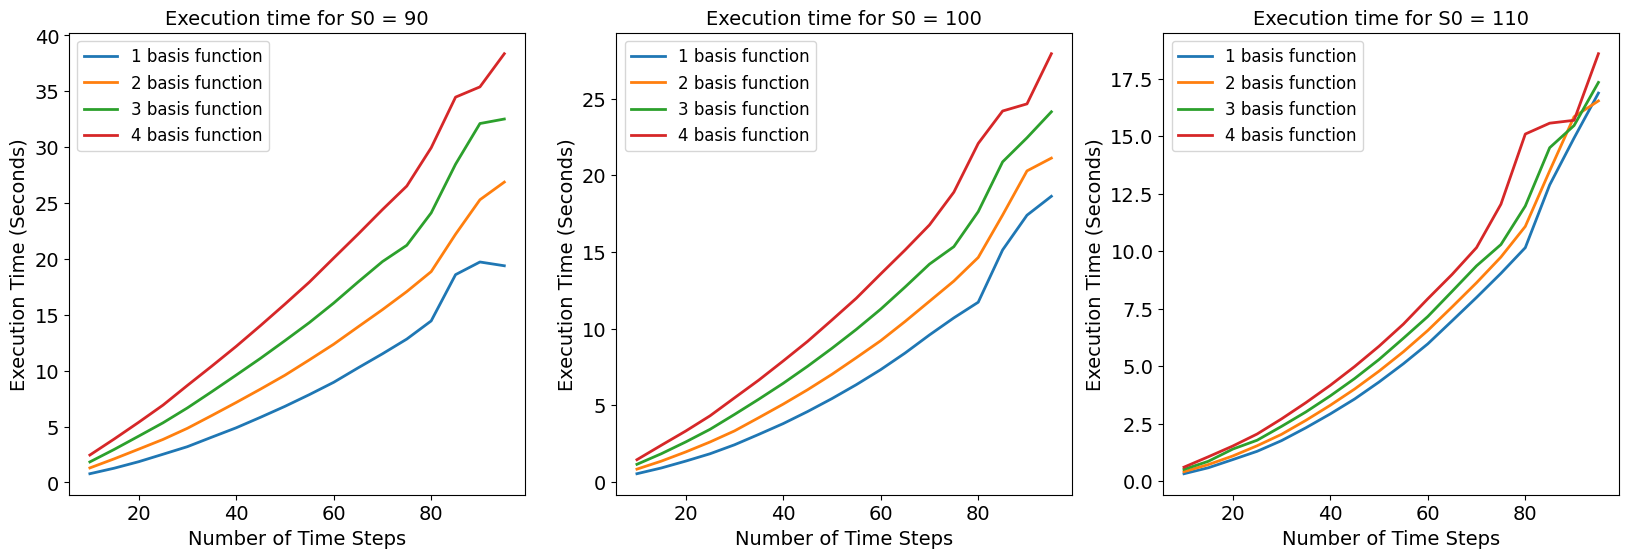

In [13]:
plot_exec_time(Exec_time)

<font face="Times Roman" size=4>
    $\qquad$First of all, the following content invovles the true value of American put options. And the author provide with a table of values, but he did not point out how he got them. I think this is not so good, since our results rely on these values very much.<br>
    $\qquad$I will use a python package of PDE method to verify the values given by the author, which is in the Appendix. They are proved to be reasonable and accurate and let us move on.
</font>

<font face="Times Roman" size=4>
    <br>
    $\qquad$As we can see in the graphs, they do not show perfect linearity in python environment. It seems that they look like convex functions. And as time steps increase, execution times become more volatile. <br>
    $\qquad$Morever, I also suspect the authenticity of the author's report a little bit. Since I only simulate $10^4$ paths with $95$ time steps in the end. This running time is about $40$ sec which is closed to his that simulated $10^6$ with $200$ time steps, which is $600$ times as much computation as me. And I have also used Brownian Bridge to improve the algorithm. I think it is unbelievable.
</font>

In [14]:
def plot_relative_error(Lsmp_price):
    true_P = {90: 10.726486710094511, 100: 4.820608184813253, 110: 1.828207584020458}
    index = Lsmp_price[90][1].index
    fig = plt.figure(figsize=(20, 6))
    for i, S in enumerate([90, 100, 110]):
        ax = fig.add_subplot(1, 3, i + 1)
        plot_min = (Lsmp_price[S][1] / true_P[S] - 1).mean(axis = 1).min()
        for d in range(1, 5, 1):
            ax.plot(index, (Lsmp_price[S][d] / true_P[S] - 1).mean(axis = 1), lw = 1, ls = '--', label = "%s basis function" % str(d))
        ax.plot((index[0], index[-1]), (0, 0), lw = 1, ls = '--', c = 'k')
        ax.set_title("Relative error for S0 = %s" % str(S), fontsize = 14)
        ax.legend(fontsize=12)
        ax.set_xlim(index[0] - 1, index[-1] + 1)
        ax.set_ylim(plot_min - 0.002, 0.004)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Number of Time Steps", fontsize=14)
        if i == 0:
            plt.ylabel("Relative Error", fontsize=14)

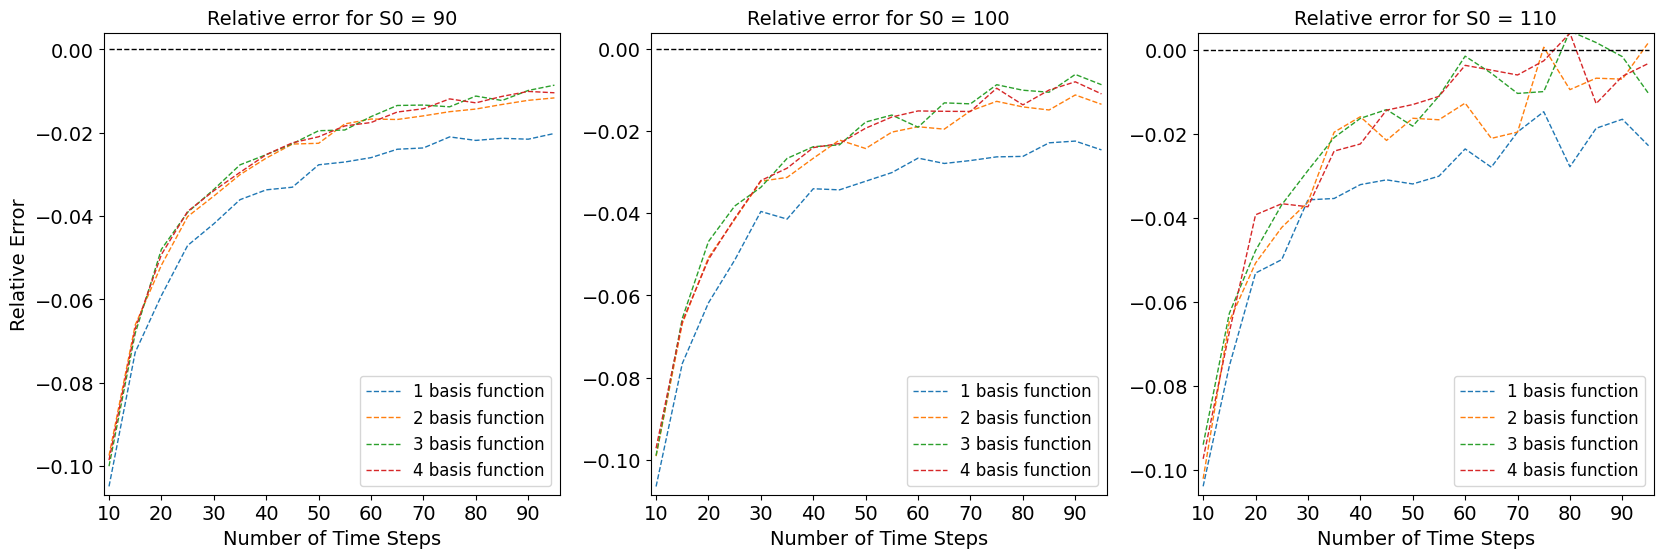

In [15]:
plot_relative_error(Lsmp_price)

<font face="Times Roman" size=4>
    $\qquad$As we can see in the graphs, the results resemble the author to some extent. However, since my sample paths is $\dfrac{1}{100}$ of his, in theory my errors are supposed to 10 times larger than his results, in this point, I think both of his and mine are roughly right.<br>
    $\qquad$Unfortunately, I do not have enough time to increase the time steps to see the clear trends, they are not obvious when time steps is $95$. There are some works to be done in the future.<br>
    $\qquad$Finally, we can see that when initial stock price is $110$, the result is not stable. I think it is partially because that the not enough sample paths cause the exercised paths very few. So it is necessary to increase the number of sample paths.<br>
    <br>
    $\qquad$Last thing to notice is that all of the graphs show that Longstaff-Schwartz method is likely to underestimate the put option value which is also mentioned by the author in his conclusion. However, the strength of this technique is to find the exercise boundaries!
</font>

In [16]:
def plot_estimated_option(Lsmp_price):
    true_P = {90: 10.726486710094511, 100: 4.820608184813253, 110: 1.828207584020458}
    Estimation = {}
    Estimation[90] = Lsmp_price[90][4].copy()
    Estimation[100] = Lsmp_price[100][4].copy()
    Estimation[110] = Lsmp_price[110][3].copy()

    sorted_Estimation = {}
    for S in Estimation.keys():
        sorted_Estimation[S] = pd.DataFrame([], columns = Estimation[S].columns, index = Estimation[S].index)
        for i in range(Estimation[S].shape[0]):
            sorted_Estimation[S].iloc[i, :] = Estimation[S].iloc[i, :].sort_values(ignore_index = True).values
    
    index = sorted_Estimation[90][1].index
    fig = plt.figure(figsize=(20, 6))
    for i, S in enumerate([90, 100, 110]):
        ax = fig.add_subplot(1, 3, i + 1)
        ax.plot((index[0], index[-1]), (true_P[S], true_P[S]), lw = 1, ls = '--', c = 'k', label = "true value", zorder = 2)
        ax.plot(index, sorted_Estimation[S].mean(axis=1), lw = 1, ls = '-', label = "sample mean of estimated values", zorder = 2)
        ax.plot(index, sorted_Estimation[S].iloc[:, 1], lw = 1, ls = '--', c = 'r')
        ax.plot(index, sorted_Estimation[S].iloc[:, -2], lw = 1, ls = '--', c = 'r', label = "90% confidence interval (nonparametric)", zorder = 2)
        for i in range(20):
            ax.scatter(index, sorted_Estimation[S].iloc[:,i], c = 'k', s = 1, label = "estimated values" if i == 0 else "", zorder = 1)
             
        ax.set_title("Computed Put Option Value for S0 = %s" % str(S), fontsize = 14)
        ax.legend(fontsize=12)
        ax.set_xlim(index[0] - 1, index[-1] + 1)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Number of Time Steps", fontsize=14)
        if i == 0:
            plt.ylabel("Option Value", fontsize=14)

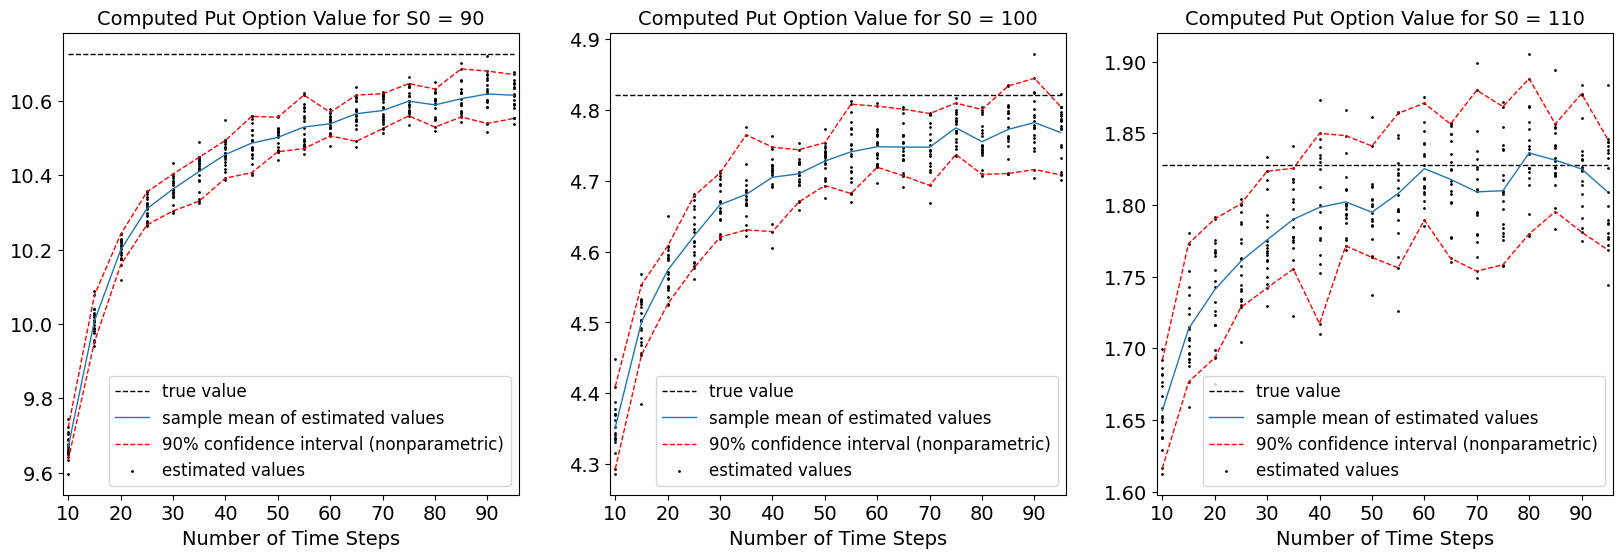

In [17]:
plot_estimated_option(Lsmp_price)

<font face="Times Roman" size=4>
    $\qquad$The conclusions that can be drawn from these graphs are similar to the previous one. The out-of-money case is volatile and has high variance because that there are few paths that are exercised. And its estimated values are the closest to the true value like what the author concluded.
</font>

# Expansion of Gustafsson's Report

<font face="Times Roman" size=4>
    In this part, I am going to plot the exercise boundaries for call and put options and have some discussion on the call options. 
</font>

In [58]:
def longstaff_schwartz_c(S0, degree, N, path = path, nreps = 20, npaths = int(1e4), export_temp_matrices = False, weighted = False):
    # degree - Laguerre basis degree
    # N - Number of time steps
    # path - export path
    # nreps - replication times
    # npaths - number of generated paths
    S = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    P = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    tstar = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    Sstar = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    
    exec_time = pd.DataFrame(index = [0], columns =[i for i in np.arange(1,nreps + 1,1)])
    lsm_price = pd.DataFrame(index = [0], columns =[i for i in np.arange(1,nreps + 1,1)])
    t = np.arange(0, 1 + 1 / N, 1 / N)[:N+1] 
    
    for i in np.arange(1,nreps + 1,1):
        # The current number of repitition
        init_time = datetime.now()
        # Antithetical sampling
        z = (t[-1] - t[0]) * np.random.randn(int(np.ceil(npaths / 2)))
        # W - value at expiry
        W = (r - 0.5 * sigma**2) * (t[-1] - t[0]) + sigma * np.append(z, -z)
        # Spot prices at expiry (a log-normal distribution)
        S[pointer(i, N)] = S0 * np.exp(W)
        # Discounted final payouts
        P[pointer(i, N)] = S[pointer(i, N)].apply(g_c)

        # Store information about early exercise
        # Exercise time for put
        tstar[pointer(i, N)] = [t[-1]] * npaths
        # Exercise price for put
        Sstar[pointer(i, N)] = S[pointer(i, N)]

        for j in range(N - 1, 0, -1):
            # The current index of time
            #  Sample for the preceding element in the bridge
            dt = t[j + 1] - t[j]
            #  Antithetical sampling of final prices:
            z = np.random.randn(int(np.ceil(npaths / 2)))
            z = np.append(z, -z)

            # Use Conclusions in Brownian Bridge to Sample the preceding element
            W = W * (t[j] / t[j+1]) + sigma * np.sqrt(dt * (t[j] / t[j+1])) * z
            S[pointer(i, j)] = S0 * np.exp(W)
            P[pointer(i, j)] = np.exp(-dt * r) * P[pointer(i, j+1)]  # Continue holding unless...
            citm = S[pointer(i, j)].apply(g_c) > 0 # Put in the money

            if citm.sum() > 0:
                x = S[pointer(i, j)][citm]  # Spot prices of each realization   
                y = P[pointer(i, j)][citm]  # Continuation value of each realization
                ind = citm[citm == True].index

                # Regression Coefficients: Laguerre basis
                design = L(x, degree = degree, weighted = weighted)
                # Regression
                # centered on zero (as per Gustaffson)
                betahat = np.dot(pinv(design), y - 0)
                # Regression value
                Chat = 0 + np.dot(design, betahat)

                # Execute early exericse
                early = ind[x.apply(g_c) > Chat]
                tstar.loc[early, pointer(i, j)] = t[j]
                Sstar.loc[early, pointer(i, j)] = S[pointer(i, j)][early]
                P.loc[early, pointer(i, j)] = S[pointer(i, j)][early].apply(g_c)

        exec_time.loc[0, i] = (datetime.now() - init_time).total_seconds()
        lsm_price.loc[0, i] = np.exp(t[0] - t[1]) * P[pointer(i, j)].mean()
    
    exec_time.to_csv(path + path_format_C % ("exec_time", str(S0), str(degree), str(N)))
    lsm_price.to_csv(path + path_format_C % ("lsm_price", str(S0), str(degree), str(N)))
    if export_temp_matrices:
        S.to_csv(path + path_format_C % ("S", str(S0), str(degree), str(N)))
        P.to_csv(path + path_format_C % ("P", str(S0), str(degree), str(N)))
        Sstar.to_csv(path + path_format_C % ("Sstar", str(S0), str(degree), str(N)))
        tstar.to_csv(path + path_format_C % ("tstar", str(S0), str(degree), str(N)))

In [20]:
longstaff_schwartz_c(S0 = 90, degree = 4, N = 100, export_temp_matrices = True)
longstaff_schwartz_c(S0 = 100, degree = 4, N = 100, export_temp_matrices = True)
longstaff_schwartz_c(S0 = 110, degree = 4, N = 100, export_temp_matrices = True)

<font face="Times Roman" size=4>
    Let us first have a look at the accuracy of call opiton pricing using Longstaff-Schwartz method. 
</font>

In [50]:
def read_lsmc_price(N, degree = 4, nreps = 20, path = path, path_format_C = path_format_C):
    Lsm_price = pd.DataFrame([], columns = [i for i in range(1, nreps+1)], index = [90, 100, 110])
    for S in [90, 100, 110]:
        Lsm_price.loc[S, :] = pd.read_csv(path + path_format_C % ("lsm_price" ,str(S), str(degree), str(N)), index_col = 0).values
    return Lsm_price

In [51]:
Lsmc_price = read_lsmc_price(100)

In [52]:
# For example (x-axis represents index of replication, y-axis represents initial stock prices)
Lsmc_price

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
90,2.554622,2.758226,2.67643,2.744739,2.663774,2.717965,2.716098,2.75756,2.752856,2.681527,2.630361,2.714231,2.725756,2.606495,2.651849,2.822659,2.770465,2.780296,2.637675,2.732805
100,7.394479,7.421231,7.514402,7.313816,7.318172,7.176712,7.428718,7.432014,7.25572,7.197481,7.303259,7.469547,7.501181,7.32306,7.354565,7.554341,7.37877,7.462057,7.358954,7.317903
110,14.600228,14.538757,14.46205,14.681731,14.56765,14.548372,14.584892,14.659305,14.535422,14.568995,14.608281,14.62412,14.599141,14.54133,14.567655,14.613299,14.553525,14.48969,14.556085,14.552984


<font face="Times Roman" size=4>
    Here are the results computed using PDE method, where the second one has more dense grid and is more accurate. (In Appendix) 
</font>

In [5]:
BS4.PDE_price((N_space1, N_time1))
BS4.PDE_price((N_space2, N_time2))

In [5]:
BS5.PDE_price((N_space1, N_time1))
BS5.PDE_price((N_space2, N_time2))

In [6]:
BS6.PDE_price((N_space1, N_time1))
BS6.PDE_price((N_space2, N_time2))

<font face="Times Roman" size=4>
    And here are the results computed using Black-Scholes formula, which are the estimations of European option prices (As well as the American option prices).
</font>

In [54]:
bs_c(90)
bs_c(100)
bs_c(110)

2.7584438561460694

7.485087593912603

14.702019669720784

<font face="Times Roman" size=4>
    Finally, take the mean of the results above and get the estimations using Longstaff-Schwartz method.
</font>

In [53]:
# Longstaff-Schwartz results
Lsmc_price.mean(axis = 1)

90      2.704820
100     7.373819
110    14.572676
dtype: float64

<font face="Times Roman" size=4>
    We can see that, for call options, the Longstaff-Schwartz method has a much larger bias compared to put option in all the cases including in-the-money, at-the-money and out-of-money. Besides, this method also tends to underestimate the prices like put option cases.<br>
    <br>
    Finally, let us have a look at the exercise boundaries for call and put options.
</font>

In [24]:
def read_tstar_Star(flag, N = 100, degree = 4, nreps = 20, path = path, path_format_P = path_format_P, path_format_C = path_format_C):
    if flag == "p":
        path_format = path_format_P
    else:
        path_format = path_format_C
    tSstar = {S: {} for S in [90, 100, 110]}
    for S in tSstar.keys():
        tstar = pd.read_csv(path + path_format % ("tstar" ,str(S), str(degree), str(N)), index_col = 0).mean(axis=0)
        tstar = pd.DataFrame(tstar.values.reshape(20, 100)).mean(axis = 0)
        Sstar = pd.read_csv(path + path_format % ("Sstar" ,str(S), str(degree), str(N)), index_col = 0)
        Sstar = pd.DataFrame(Sstar.values.reshape(200000, 100))
        tSstar[S] = (tstar, Sstar)
    return tSstar

In [25]:
tSstar_p = read_tstar_Star("p")
tSstar_c = read_tstar_Star("c")

In [68]:
def plot_exercise_boundary(flag, tSstar):
    fig = plt.figure(figsize=(20, 6))
    for i, S in enumerate([90, 100, 110]):
        tstar = tSstar[S][0]
        Sstar = tSstar[S][1]
        ax = fig.add_subplot(1, 3, i + 1)
        sorted_Sstar = pd.DataFrame([], columns = Sstar.columns, index = Sstar.index)
        for i in range(Sstar.shape[1]):
            sorted_Sstar.iloc[:, i] = Sstar.iloc[:, i].sort_values(ignore_index = True).values
        upper_std_vec = []
        lower_std_vec = []
        mean_vec = []
        for i in range(tstar.shape[0]):
            if not np.isnan(tstar[i]):
                temp = sorted_Sstar.iloc[:, i].dropna().values
                temp_range = temp[-1] - temp[0]
                mean_vec.append(temp.mean())
                upper_std_vec.append(temp.mean() + temp.std())
                lower_std_vec.append(temp.mean() - temp.std())
                if i == tstar.shape[0] - 1:
                    ax.scatter([tstar[i]] * temp.shape[0], temp, s = 1, c = 'k', alpha = 0.8, label = "exercised samples (color represents density)")
                else:
                    ax.scatter([tstar[i]] * temp.shape[0], temp, s = 0.5, c = 'k', alpha = 0.08)
        ax.plot([0, 1], [S, S], label = "initial value of stock", c = "g", ls = '--', lw = 1)
        ax.plot([0, 1], [100, 100], label = "strike price of stock", c = "orange", ls = '--', lw = 1)
        ax.plot(tstar.dropna().values[:-1], mean_vec[:-1], label = "sample mean of exercised samples")
        ax.plot(tstar.dropna().values[:-1], lower_std_vec[:-1], lw = 2, ls = '--', c = 'r', alpha = 0.8)
        ax.plot(tstar.dropna().values[:-1], upper_std_vec[:-1], lw = 2, ls = '--', c = 'r', alpha = 0.8, label = "one standard deviation confidence interval")
        ax.set_xlim(0, 1)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Time", fontsize=14)
        if flag == "c":
            ax.legend(fontsize=10)
            ax.set_title("Call Option Exercise Boundary for S0 = %s" % str(S), fontsize = 14)
        else:
            ax.legend(fontsize=12)      
            ax.set_title("Put Option Exercise Boundary for S0 = %s" % str(S), fontsize = 14)
        if S == 90:
            plt.ylabel("Prices", fontsize=14)

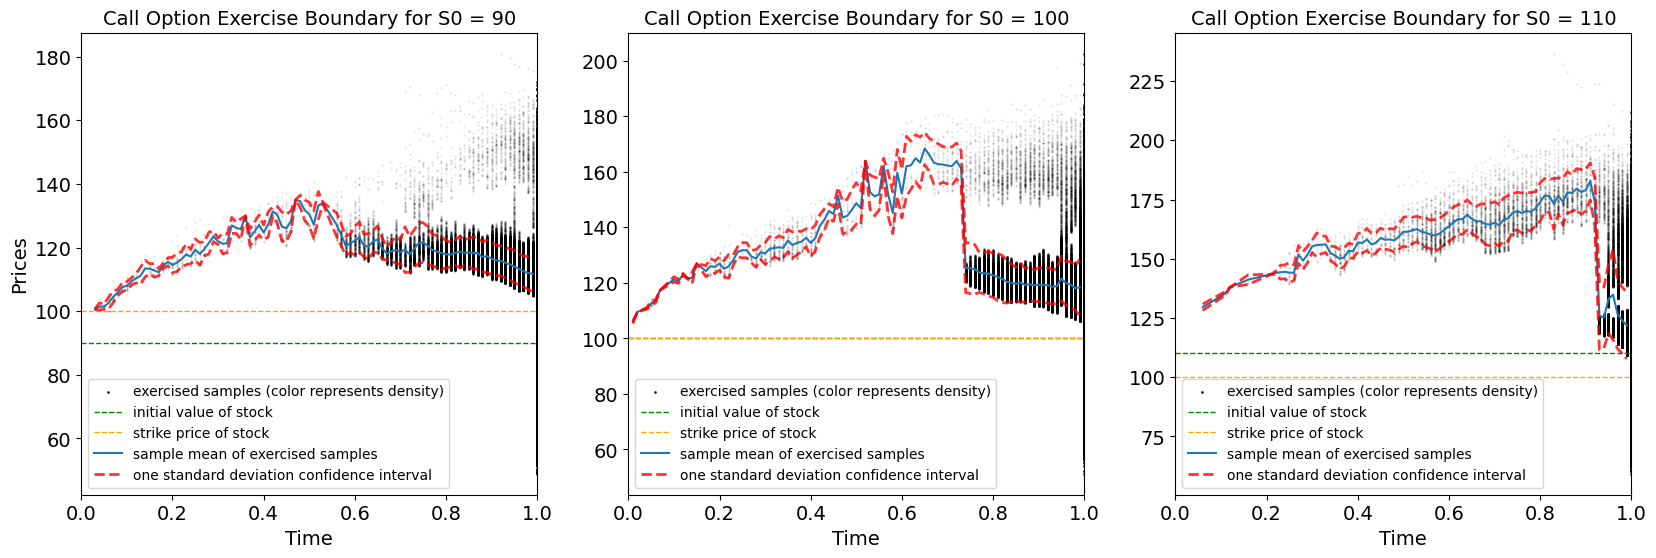

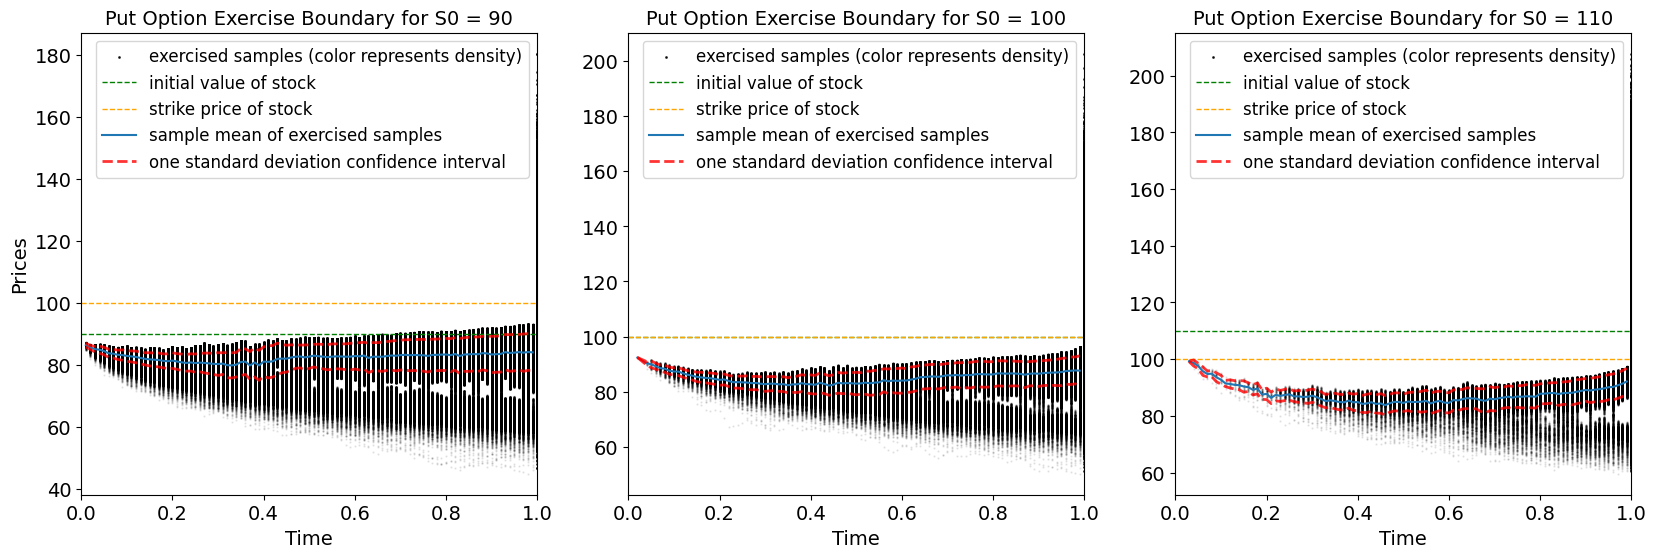

In [69]:
plot_exercise_boundary("c", tSstar_c)
plot_exercise_boundary("p", tSstar_p)

<font face="Times Roman" size=4>
    $\qquad$Firstly, we can see that, for both cases, there are much fewer exercised samples that are deep in the money than others. In other words, exercised samples clustered in somewhere not far away from the strike prices.<br>
    $\qquad$And we can see that it seems that the put options are more stable and have lower variances that call options, which tells us Longstaff-Schwartz method is more effective in pricing put options.<br>
    $\qquad$In the case of call options, though we can see that there is a abrupt decreasing closed to the end and thus is not so reliable. But maybe we could get a smoother curve by simulating more paths. And this is very intuitive, as time goes by, for those who have American call options which are sightly higher than strike price tend to early exercise. And at very beginning, if there is a very high intrinsic value, people tend to exercise instead of following the textbook and holding them. <br>
    $\qquad$Thus I think maybe Longstaff-Schwartz method is not that bad at pricing American call option.
</font>

# Further work

<font face="Times Roman" size=4>
    Of course there are a lot of things to be done in the future. This report just simply analyze how to compute the American options using Monte Carlo method, which is very good at finding their exercise boundaries, but is likely to suffer from low speed and large memory cost.<br>
    <br>
    Here are some interesting topics:
    <ul>
    <li>What would happen if we use different function polynomials like Hermite, Legendre, Chebyshev, Gegenbauer, and Jacobi polynomial. </li>
    <br>
    <li>What would happen if we use weighted Laguerre polynomials where the author said that it was more inaccurate</li>
    <br>
    <li>Would the results converge if we use more time steps.</li>
    <br>
    <li>Would the results converge if we use more degrees of polynomial.</li>
    <br>
    <li>How good the regression step works (What professor has done in the class).</li> 
    </ul>
</font>

In [ ]:
#longstaff_schwartz_c(S0 = 90, degree = 4, N = 100, export_temp_matrices = True, weighted = True)
#longstaff_schwartz_c(S0 = 100, degree = 4, N = 100, export_temp_matrices = True, weighted = True)
#longstaff_schwartz_c(S0 = 110, degree = 4, N = 100, export_temp_matrices = True, weighted = True)

In [ ]:
#longstaff_schwartz_p(S0 = 90, degree = 4, N = 100, export_temp_matrices = True, weighted = True)
#longstaff_schwartz_p(S0 = 100, degree = 4, N = 100, export_temp_matrices = True, weighted = True)
#longstaff_schwartz_p(S0 = 110, degree = 4, N = 100, export_temp_matrices = True, weighted = True)

In [ ]:
# Other Choice (Non-equally spaced times)
# npaths = int(10000)
# timestep = 0.002
# t = np.arange(0, 1 + timestep, timestep)**(1/5)

# mono = 0  
# mono - use monotone regression instead of polynomial least squares


for k in range(N-1, 0, -1):   
    #  Sample for the preceding element in the bridge
    dt = t[k+1] - t[k]
    #  Antithetical sampling of final prices:
    z = np.random.randn(int(np.ceil(npaths / 2)))
    z = np.append(z, -z)

    # Use Conclusions in Brownian Bridge to Sample the preceding element
    W = W * (t[k] / t[k+1]) + sigma * np.sqrt(dt * (t[k] / t[k+1])) * z
    S = S0 * np.exp(W)
    P = np.exp(-dt * r) * P  # Continue holding unless...
    citm, pitm = (np.array([list(map(g_c, S)), list(map(g_p, S))]) > 0) # Call and Put in the money
    BSC, BSP = np.array([list(map(bs_c, S)), list(map(bs_p, S))]) # Black Scholes Prices for analysis

    if sum(pitm) > 0:
        x = S[pitm]  # Spot prices of each realization   
        # Sort in ascending order
        x, jj = np.sort(x), np.argsort(x)
        y = P[1, :][pitm][jj]  # Continuation value of each realization
        Eo = BSP[pitm][jj]  # Value of 'European' continuation
        ind = np.where(pitm == True)[0][jj]

        # Regression Coefficients: Laguerre basis
        design = L(x, degree = 4)

        # Regression
        # centered on zero (as per Gustaffson)
        betahat = np.dot(inv(np.dot(design.T, design)), np.dot(design.T, y - 0))
        # Regression value
        Chat = 0 + np.dot(design, betahat)

        # Nonparametric monotone fit for Put option centered on zero
        # mChat = 0 + Isotonic().fit_transform(x, y - 0)
        # mChat = np.maximum(Eo, mChat)

        # Nonparametric monotone fit for Put option
        mChat = list(map(g_p, x)) + Isotonic().fit_transform(x, y - list(map(g_p, x)))
        # mChat = np.maximum(Eo, mChat)

        #ax2.plot(x, y - list(map(g_p, x)), c = "k", marker = '.', linestyle = '', label = "Discounted Continuation")
        #ax2.plot(x, mChat - list(map(g_p, x)), c = "orange", linewidth = 2, label = "Monotone Fit Continuation")
        #ax2.plot(x, Eo - list(map(g_p, x)), c = "m", linewidth = 2, label = "European Continuation")
        #ax2.plot(x, Chat - list(map(g_p, x)), c = "r", linewidth = 2, label = "Fit Continuation")
        #ax2.plot([x[0], x[-1]], [0, 0], c = "g", linewidth = 1, label = "Current Payout")
        #ax2.set_xlim(x[0], x[-1])
        #ax2.set_ylim(-20, 20)
        #ax2.set_title("Put")

        # Execute early exericse
        if not mono:
            early = ind[list(map(g_p, x)) > Chat]
        else:
            early = ind[list(map(g_p, x)) > mChat]

        tstar[1, early] = t[k]
        Sstar[1, early] = S[early]
        P[1, early] = list(map(g_p, S[early]))
    
    
    if sum(citm) > 0:
        x = S[citm]  # Spot prices of each realization   
        # Sort in descending order
        x, ii = np.sort(x)[::-1], np.argsort(x)[::-1]
        y = P[0, :][citm][ii]  # Continuation value of each realization
        Eo = BSC[citm][ii]  # Value of 'European' continuation
        ind = np.where(citm == True)[0][ii]

        # Regression Coefficients: Laguerre basis
        design = L(x, degree = 4)

        # Regression
        # centered on zero (as per Gustaffson)
        betahat = np.dot(inv(np.dot(design.T, design)), np.dot(design.T, y - 0))
        # Regression value
        Chat = 0 + np.dot(design, betahat)

        # Nonparametric monotone fit for Put option centered on zero
        # mChat = 0 - Isotonic().fit_transform(x, 0 - y)
        # mChat = np.maximum(Eo, mChat)

        # Nonparametric monotone fit for Put option
        mChat = list(map(g_c, x)) - Isotonic().fit_transform(x, list(map(g_c, x)) - y)
        # mChat = np.maximum(Eo, mChat)

        Chat = np.maximum(0, Chat)
        mChat = np.maximum(0, mChat)
        
        #ax3.plot(x, y - list(map(g_c, x)), c = "k", marker = '.', linestyle = '', label = "Discounted Continuation")
        #ax3.plot(x, mChat - list(map(g_c, x)), c = "orange", linewidth = 2, label = "Monotone Fit Continuation")
        #ax3.plot(x, Eo - list(map(g_c, x)), c = "m", linewidth = 2, label = "European Continuation")
        #ax3.plot(x, Chat - list(map(g_c, x)), c = "r", linewidth = 2, label = "Fit Continuation")
        #ax3.plot([x[-1], x[0]], [0, 0], c = "g", linewidth = 1, label = "Current Payout")
        #ax3.set_xlim(x[-1], x[0])
        #ax3.set_ylim(-20, 20)
        #ax3.set_title("Call")

        # Execute early exericse
        if not mono:
            early = ind[list(map(g_c, x)) > Chat]
        else:
            early = ind[list(map(g_c, x)) > mChat]

        tstar[0, early] = t[k]
        Sstar[0, early] = S[early]
        P[0, early] = list(map(g_c, S[early]))
    
    ax1.plot(tstar[0, :], Sstar[0, :], c = '#1f77b4', marker = '.', markersize = 3, linestyle = '')   
    ax1.plot(tstar[1, :], Sstar[1, :], c = '#ff7f0e', marker = '.', markersize = 3, linestyle = '')
    ax1.set_title("Exercise Boundary")
    
lsmc_c = np.exp(t[0] - t[1]) * P[0, :].mean()
lsmc_p = np.exp(t[0] - t[1]) * P[1, :].mean()

# Appendix - PDE method for American Option

<font size = 4> _References_ </font> </br>
* Financial-Models-Numerical-Methods<br>
https://github.com/cantaro86/Financial-Models-Numerical-Methods

In [3]:
from functions.BS_pricer import BS_pricer
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process
from functions.cython.cython_functions import PSOR
from IPython.display import display

import scipy.stats as ss
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))

In [4]:
# Creates the object with the parameters of the option
opt_param1 = Option_param(S0=90, K=100, T=1, exercise="American", payoff="put")
opt_param2 = Option_param(S0=100, K=100, T=1, exercise="American", payoff="put" )
opt_param3 = Option_param(S0=110, K=100, T=1, exercise="American", payoff="put" )
opt_param4 = Option_param(S0=90, K=100, T=1, exercise="American", payoff="call" )
opt_param5 = Option_param(S0=100, K=100, T=1, exercise="American", payoff="call" )
opt_param6 = Option_param(S0=110, K=100, T=1, exercise="American", payoff="call" )
# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.03, sig=0.15)
# Creates the pricer object
BS1 = BS_pricer(opt_param1, diff_param)
BS2 = BS_pricer(opt_param2, diff_param)
BS3 = BS_pricer(opt_param3, diff_param)
BS4 = BS_pricer(opt_param4, diff_param)
BS5 = BS_pricer(opt_param5, diff_param)
BS6 = BS_pricer(opt_param6, diff_param)
# PDE parameters
N_space1, N_time1 = 10000, 10000
N_space2, N_time2 = 40000, 40000

In [20]:
BS1.PDE_price((N_space1, N_time1))
BS1.PDE_price((N_space2, N_time2))

In [21]:
BS2.PDE_price((N_space1, N_time1))
BS2.PDE_price((N_space2, N_time2))

In [4]:
BS3.PDE_price((N_space1, N_time1))
BS3.PDE_price((N_space2, N_time2))

In [5]:
BS4.PDE_price((N_space1, N_time1))
BS4.PDE_price((N_space2, N_time2))

In [5]:
BS5.PDE_price((N_space1, N_time1))
BS5.PDE_price((N_space2, N_time2))

In [6]:
BS6.PDE_price((N_space1, N_time1))
BS6.PDE_price((N_space2, N_time2))